In [ ]:
!pip install gtsam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 33.4 MB/s eta 0:00:00


1A: Processing g2o file

In [ ]:
import gtsam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

def read_g2o(filename):

  data_2d = pd.read_csv(filename, delimiter = ' ', names = list('abcdefghijkl'))
  data_2d.to_csv("data_2d.csv", index=None)

  df = pd.read_csv("data_2d.csv")

  vertices_no = 0
  edges_no = 0

  for i in range(df.shape[0]):

    if df.loc[i][0] == "VERTEX_SE2":
      vertices_no+=1
    elif df.loc[i][0] == "EDGE_SE2":
      edges_no+=1

  vertices_store = np.zeros((vertices_no,4))
  edges_store = np.zeros((edges_no,11))

  for j in range(vertices_no):

    vertices_store[j,:] = df.loc[j][1:5]

  for k in range(edges_no):

    edges_store[k,:] = df.loc[vertices_no+k][1:13]

  return vertices_store, edges_store

def get_information_matrix(edges_store):

  info_matrix_store = np.zeros((edges_store.shape[0],3,3))

  for i in range(edges_store.shape[0]):

    q11,q12,q13,q22,q23,q33  = edges_store[i,5:]

    info_matrix = np.array([[q11,q12,q13],[q12,q22,q23],[q13,q23,q33]])
    info_matrix_store[i,:,:] = info_matrix

  return info_matrix_store

vertices_store, edges_store = read_g2o("input_INTEL_g2o.g2o")
info_matrix_store = get_information_matrix(edges_store)

1B: 2D Batch Solution

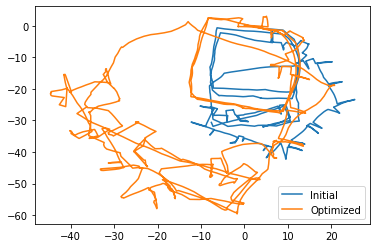

In [ ]:
graph = gtsam.NonlinearFactorGraph()

priorMean = gtsam.Pose2(0.0, 0.0, 0.0)
priorNoise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.1]))
graph.add(gtsam.PriorFactorPose2(1, priorMean, priorNoise))

for i in range(edges_store.shape[0]):

  odometryNoise = gtsam.noiseModel.Gaussian.Information(info_matrix_store[i])
  graph.add(gtsam.BetweenFactorPose2(int(edges_store[i,0]), int(edges_store[i,1]), gtsam.Pose2(edges_store[i,2], edges_store[i,3], edges_store[i,4]), odometryNoise))

initialEstimate = gtsam.Values()

for j in range(vertices_store.shape[0]):

  pose_est = gtsam.Pose2(vertices_store[j,1],vertices_store[j,2],vertices_store[j,3])
  initialEstimate.insert(int(vertices_store[j,0]), pose_est)

optimizer = gtsam.GaussNewtonOptimizer(graph, initialEstimate)
result = optimizer.optimizeSafely()

optimized_store = np.zeros((vertices_store.shape[0],3))

for k in range(vertices_store.shape[0]):

  optimized_store[k,:] = [result.atPose2(k).x(),result.atPose2(k).y(),result.atPose2(k).theta()]

plt.figure()
plt.plot(vertices_store[:,1],vertices_store[:,2])
plt.plot(optimized_store[:,0],optimized_store[:,1])
plt.legend(["Initial","Optimized"])
plt.show()

1C:2D Incremental Solution

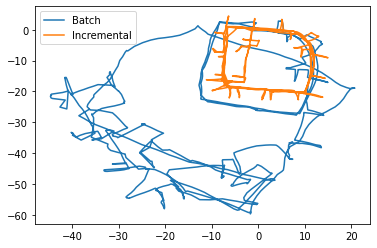

In [ ]:
def incremental_solution_2d(poses, edges):

  isam = gtsam.ISAM2()
  result = None

  def construct_covariance(info_vector):

    q11,q12,q13,q22,q23,q33  = info_vector
    info_matrix = np.array([[q11,q12,q13],[q12,q22,q23],[q13,q23,q33]])

    return info_matrix

  for i in range(poses.shape[0]):

    graph = gtsam.NonlinearFactorGraph()
    initialEstimate = gtsam.Values()

    if poses[i,0] == 0:

      priorMean = gtsam.Pose2(poses[i,1],poses[i,2],poses[i,3])
      priorNoise = gtsam.noiseModel.Diagonal.Sigmas(np.array([0.3, 0.3, 0.1]))
      graph.add(gtsam.PriorFactorPose2(0, priorMean, priorNoise))

      initialEstimate.insert(int(poses[i,0]), priorMean)

    else:

      prevPose = result.atPose2(i-1)
      initialEstimate.insert(int(poses[i,0]), prevPose)

      for j in range(edges.shape[0]):

        if edges[j,1] == poses[i,0]:

          info = construct_covariance(edges[j,5:])
          odometryNoise = gtsam.noiseModel.Gaussian.Information(info)
          graph.add(gtsam.BetweenFactorPose2(int(edges[j,0]), int(edges[j,1]), gtsam.Pose2(edges[j,2], edges[j,3], edges[j,4]), odometryNoise))

    isam.update(graph, initialEstimate)
    result = isam.calculateEstimate()

  return result

result = incremental_solution_2d(vertices_store, edges_store)

incremental_store = np.zeros((vertices_store.shape[0],3))

for k in range(vertices_store.shape[0]):

  incremental_store[k,:] = [result.atPose2(k).x(),result.atPose2(k).y(),result.atPose2(k).theta()]

plt.figure()
plt.plot(optimized_store[:,0],optimized_store[:,1])
plt.plot(incremental_store[:,0],incremental_store[:,1])
plt.legend(["Batch","Incremental"])
plt.show()